In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
import numpy as np
torch.set_default_dtype(torch.float64)

## Results
SNR generally lower for DReG multi-sample estimate that straight KL estimate

# Setup

In [3]:
from FittedModels.Utils.analysis_utils import estimate_key_info

In [82]:
def get_vars(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.var(run_list, axis=0, ddof=1)[index1, index2] for run_list in hist_list]

In [83]:
def get_means(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.mean(run_list, axis=0)[index1, index2] for run_list in hist_list]

In [84]:
def get_SNR(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.abs(np.mean(run_list, axis=0)[index1, index2])/np.std(run_list, axis=0, ddof=1)[index1, index2] for run_list in hist_list]

In [85]:
def get_coeff_of_variation(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.std(run_list, axis=0, ddof=1)[index1, index2]/np.abs(np.mean(run_list, axis=0)[index1, index2]) for run_list in hist_list]

# Easy problem

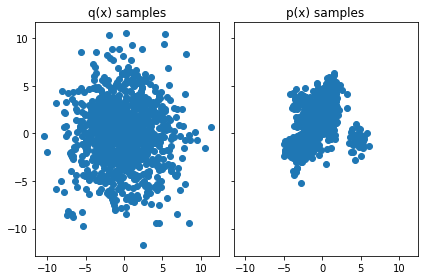

In [103]:
torch.manual_seed(0) 
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=2, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [104]:
alpha_2_grads_1_list, alpha_2_grads_2_list, kl_DReG_grads_1_list, \
           kl_DReG_grads_2_list, kl_grads_1_list, kl_grads_2_list, \
            n_points_space = \
                    estimate_key_info(tester, max_n_samples=1e5, min_n_samples=100, n_runs_max=10)

100%|██████████| 4/4 [23:10<00:00, 347.56s/it] 


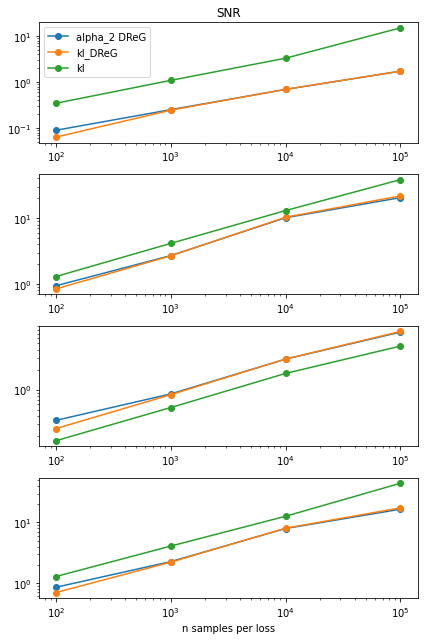

In [105]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("SNR")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_SNR(alpha_2_grads_1_list, i), "o-", label="alpha_2 DReG")
    axs[i].plot(n_points_space, get_SNR(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_SNR(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

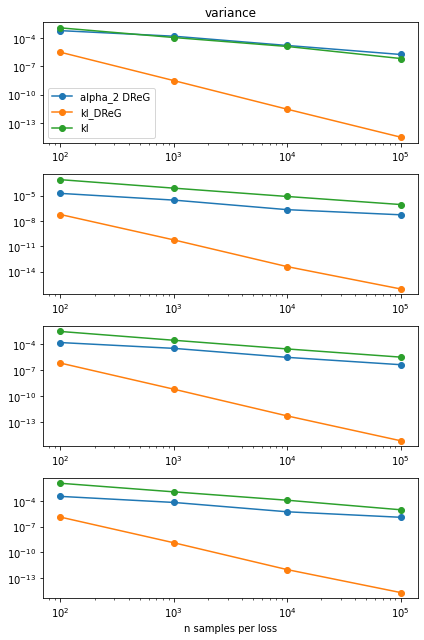

In [106]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("variance")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_vars(alpha_2_grads_1_list, i), "o-", label="alpha_2 DReG")
    axs[i].plot(n_points_space, get_vars(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_vars(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

# Harder Problem

In [3]:
# copying a problem where there was often difficulty getting good performance
lr=1e-2; optimizer="Adamax"; seed=0; epochs = int(5e3); dim = 3
# ******************* Parameters *******************
n_samples_estimation = int(1e7)
batch_size = int(1e3)
initial_flow_scaling = 10.0
n_flow_steps = 3
torch.manual_seed(seed)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, n_samples_estimation)
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=initial_flow_scaling) # , flow_type="RealNVP", use_exp=True
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG",
                                   lr=lr, optimizer=optimizer)

/anaconda/envs/pytorch/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 803: system has unsupported display driver / cuda driver combination (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554793803/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


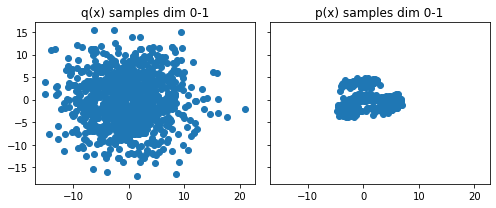

In [6]:
plot_samples(tester)

In [108]:
"""
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 3
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions
"""

'\ntorch.manual_seed(0) # 0 breaks it within 1000 epochs\ndim = 3\nn_samples_estimation = int(1e4)\ntarget = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)\ntrue_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))\ntorch.manual_seed(1)\nlearnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")\ntester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)\nexpectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)\nsamples_fig_before = plot_samples(tester) # this just looks at 2 dimensions\n'

In [109]:
alpha_2_grads_1_list, alpha_2_grads_2_list, kl_DReG_grads_1_list, \
           kl_DReG_grads_2_list, kl_grads_1_list, kl_grads_2_list, \
            n_points_space = \
                    estimate_key_info(tester, max_n_samples=1e5, min_n_samples=100, n_runs_max=10)

100%|██████████| 4/4 [34:58<00:00, 524.53s/it]   


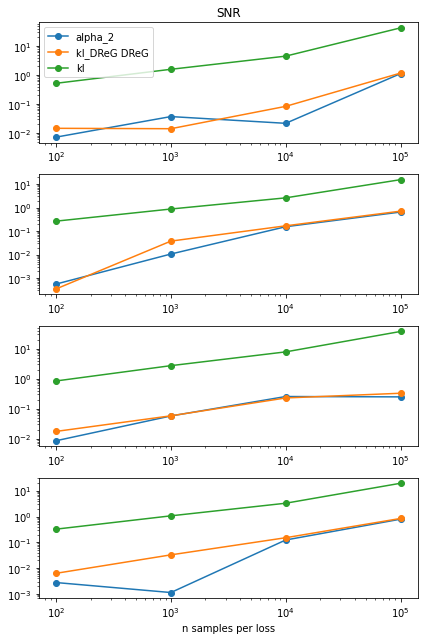

In [110]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("SNR")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_SNR(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_SNR(kl_DReG_grads_1_list, i), "o-", label="kl_DReG DReG")
    axs[i].plot(n_points_space, get_SNR(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

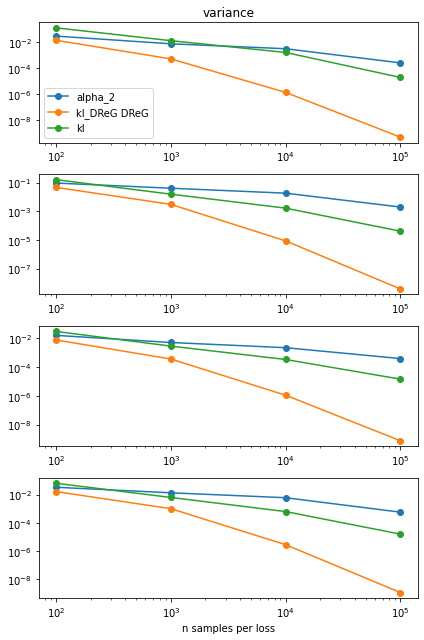

In [111]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("variance")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_vars(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_vars(kl_DReG_grads_1_list, i), "o-", label="kl_DReG DReG")
    axs[i].plot(n_points_space, get_vars(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

# Harder harder Problem

In [ ]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 6
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [ ]:
kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, int(1e6), min_n_samples=100)

In [ ]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("SNR")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_SNR(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_SNR(kl_DReG_grads_1_list, i), "o-", label="kl_DReG DReG")
    axs[i].plot(n_points_space, get_SNR(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()